In [268]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [269]:
class Value:
    def __init__(self,data, _children=(), _op='',label='',grad=0):
        self.data=data
        self.prev = set(_children)
        self.op=_op
        self.label=label
        self.grad=grad # Initialize grad to 0
        self._backward=lambda: None 
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        if not isinstance(other, Value):  
            other = Value(other)
        out = Value(self.data ** other.data, (self, other), 'pow')
        def _backward():
            self.grad += (other.data * self.data ** (other.data - 1)) * out.grad
            if self.data > 0:  
                other.grad += (self.data ** other.data) * math.log(self.data) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + other * -1
    
    def __neg__(self):
        return self * -1

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self * other**-1
    
    def __radd__(self, other):
        return self + other 

    def __rsub__(self, other):
        return other + (-self)

    def __rtruediv__(self, other):
        return other * self**-1
    
    def exp(self):
        x=self.data
        e = math.exp(x)
        out = Value(e, (self,), 'exp')
        def _backward():
            self.grad += e * out.grad
        out._backward = _backward
        return out 

    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0  # set the gradient of the output node
        for v in reversed(topo):
            v._backward() 

a = Value(2.0, label='a')
b = Value(3.0, label='b')
c=a/b
c

Value(data=0.6666666666666666)

In [270]:
# VISUALIZATION

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n.op, label=n.op)
            # and connect this node to it
            dot.edge(uid + n.op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot


`Perceptron`

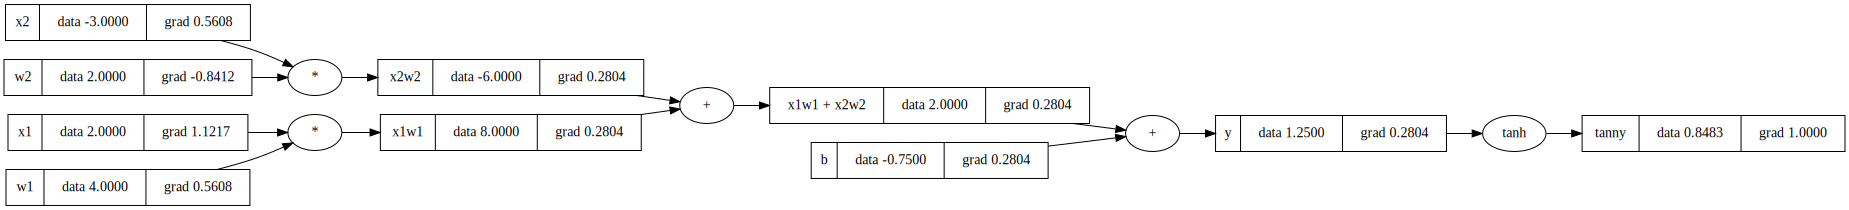

In [271]:
x1 = Value(2, label='x1')
x2 = Value(-3, label='x2')
w1 = Value(4, label='w1')
w2 = Value(2, label='w2')
b = Value(-0.75, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
y = x1w1x2w2 + b; y.label = 'y'
tanny = y.tanh(); tanny.label = 'tanny'
tanny.backward()
draw_dot(tanny)

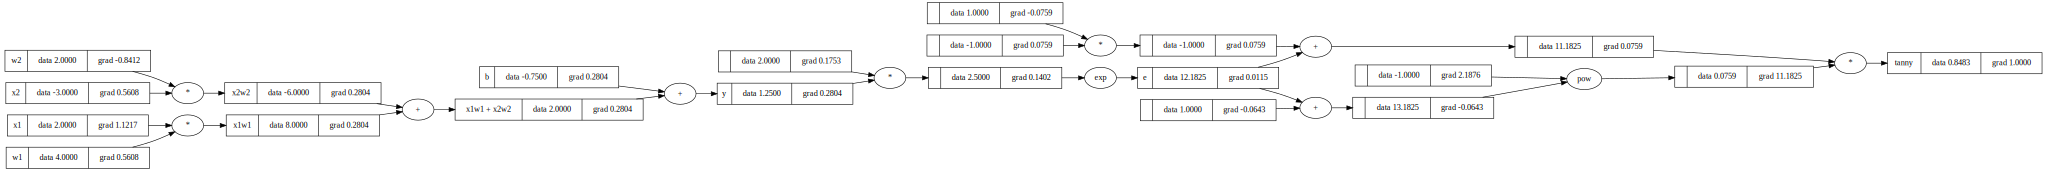

In [272]:
x1 = Value(2, label='x1')
x2 = Value(-3, label='x2')
w1 = Value(4, label='w1')
w2 = Value(2, label='w2')
b = Value(-0.75, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
y = x1w1x2w2 + b; y.label = 'y'
############
e= (2*y).exp(); e.label = 'e'
tanny = (e-1)/(1+e); tanny.label = 'tanny'
############
tanny.backward()
draw_dot(tanny)

**Works same for torch**

In [273]:
import torch
x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(-3.0, requires_grad=True)
w1 = torch.tensor(4.0, requires_grad=True)
w2 = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(-0.75, requires_grad=True)
tanny = torch.tanh(x1 * w1 + x2 * w2 + b)
tanny.backward()
print(f"x1.grad: {x1.grad}, x2.grad: {x2.grad}, w1.grad: {w1.grad}, w2.grad: {w2.grad}, b.grad: {b.grad}")
print(tanny.item())

x1.grad: 1.1216593980789185, x2.grad: 0.5608296990394592, w1.grad: 0.5608296990394592, w2.grad: -0.8412445783615112, b.grad: 0.2804148495197296
0.8482836484909058


**Multilayer Perceptron Now**

In [274]:
import random

In [275]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1), label=f'w{i}') for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')
    
    def __call__(self, x):
        act = sum(w_i * x_i for w_i, x_i in zip(self.w, x)) + self.b
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        self.layers = [Layer(nin, nout) for nout in nouts]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [527]:
x=[2,3,-1]
n = MLP(3, [4, 4, 1])
print(n(x))  # Forward pass

Value(data=-0.41051177090080865)


In [528]:
len(n.parameters())  # Get all parameters

36

In [529]:
xs = [
    [2, 3, -1],
    [1, 2, 0],
    [-1, -2, -3],
    [0, 0, 0],
    [4, 5, 6]
]

ys = [1, -1, -1, 1, 1]  # Example labels for binary classification
y_pred = [n(x) for x in xs]  # Forward pass for all inputs
y_pred

[Value(data=-0.41051177090080865),
 Value(data=-0.44619990013202726),
 Value(data=-0.44362946708733175),
 Value(data=-0.3958146256185256),
 Value(data=-0.19836890043888095)]

In [530]:
loss =sum([(yout-ygt)**2 for ygt,yout in zip(ys, y_pred)])
loss

Value(data=5.990172666986715)

In [531]:
loss.backward()  # Backward pass to compute gradients
n.layers[0].neurons[0].w[0].grad

0.5261503315518752

In [532]:
n.layers[0].neurons[0].w[0].data

0.5536957148617474

In [ ]:
for epoch in range(500):
    
    # Forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys, y_pred)])
    
    # Zero gradients
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    # Update parameters
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(f"Epoch {epoch}, Loss: {loss.data}")

# HENCE STEPS :
# 1. Initialize the model (MLP) with random weights and biases.
# 2. For each epoch:
#    a. Perform a forward pass to compute predictions.
#    b. Compute the (sum of) loss using the predictions and ground truth labels.
#    c. Zero the gradients of all parameters.
#    d. Perform a backward pass to compute gradients.
#    e. Update the parameters using the gradients and a learning rate.
# 3. Repeat until convergence or for a fixed number of epochs.

Epoch 0, Loss: 0.0003450427195565669
Epoch 1, Loss: 0.00034501310778690047
Epoch 2, Loss: 0.0003449835009639544
Epoch 3, Loss: 0.00034495389908649504
Epoch 4, Loss: 0.0003449243021532922
Epoch 5, Loss: 0.00034489471016312643
Epoch 6, Loss: 0.00034486512311477583
Epoch 7, Loss: 0.000344835541007
Epoch 8, Loss: 0.0003448059638385938
Epoch 9, Loss: 0.0003447763916083248
Epoch 10, Loss: 0.00034474682431496806
Epoch 11, Loss: 0.0003447172619573051
Epoch 12, Loss: 0.0003446877045341089
Epoch 13, Loss: 0.000344658152044158
Epoch 14, Loss: 0.00034462860448623286
Epoch 15, Loss: 0.0003445990618591172
Epoch 16, Loss: 0.0003445695241615827
Epoch 17, Loss: 0.0003445399913924078
Epoch 18, Loss: 0.0003445104635503784
Epoch 19, Loss: 0.0003444809406342723
Epoch 20, Loss: 0.000344451422642867
Epoch 21, Loss: 0.00034442190957494073
Epoch 22, Loss: 0.0003443924014292902
Epoch 23, Loss: 0.00034436289820468453
Epoch 24, Loss: 0.0003443333998999065
Epoch 25, Loss: 0.00034430390651374554
Epoch 26, Loss: 0.0

In [573]:
print(y_pred)

[Value(data=0.990123196678838), Value(data=-0.9892604864616473), Value(data=-0.9931312080419681), Value(data=0.9933790686799301), Value(data=0.994808526199631)]
